In [1]:
'''
NOTE: Requires latest version of Jax - previous versions (before 06/20)
don't have pathwise implicit derivatives for gamma/dirichlet nor
derivatives of digamma/polygamma function.
'''
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax.ops import index, index_add, index_update
import jax.scipy.special as sc
from jax.flatten_util import ravel_pytree
import jax

In [2]:
import matplotlib.pyplot as plt
import dill
import types
import warnings
from copy import deepcopy
from tqdm.notebook import tqdm

In [3]:
key = random.PRNGKey(41310)
key

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray([    0, 41310], dtype=uint32)

In [4]:
# Load defined models and trajectories
'''
ADNI trajectories - privacy regulations mean I can't make them available but
this is the script I used
'''
with open('adni-trajs.obj', 'rb') as f:
    trajs_raw = dill.load(f)

In [5]:
S = 3
A = 2
Z = 3 * 4

In [6]:
import numpy as onp
n = len(trajs_raw)
taus = onp.zeros(n, dtype='int')
for i in range(n):
    taus[i] = trajs_raw[i].tau
tau = taus.max()

trajs = onp.ones((n,2,tau),dtype=int) * A
trajs[:,1,:] = onp.zeros((n,tau),dtype=int)
for i in range(n):
    trajs[i][0,:trajs_raw[i].tau] = onp.array(trajs_raw[i].a)
    trajs[i][1,:trajs_raw[i].tau] = onp.array(trajs_raw[i].z)
trajs = np.array(trajs)

In [8]:
'''
Initialise parameters phi
'''
b0_p = np.ones((S)) * 30
T_p  = np.ones((S,A,S)) * 20
O_p  = np.ones((A,S,Z)) * 20

mu_p = np.ones((A,S,2))
mu_p = index_update(mu_p,index[:,:,1],np.ones((A,S))*0.6)
eta_p = np.ones(2)



In [9]:
'''
Setting the priors over the parameters
'''
b0_prior = np.ones((S)) * 3
T_prior  = np.ones((S,A,S)) * 3
O_prior  = np.ones((A,S,Z)) * 3

mu_prior = np.ones((A,S,2))
mu_prior = index_update(mu_prior,index[:,:,1],np.ones((A,S))*0.6)
eta_prior = np.ones(2)



In [10]:
'''
Define mean vector policy parameterisation
'''
@jit
def policy(mu,eta,b):
    del_a = np.exp(-eta*np.sum((b-mu)**2,axis=-1))
    del_a /= del_a.sum()
    return del_a

@jit
def keep_pos(x):
    return np.log(1+np.exp(x))

In [11]:
'''
Sample some inital values
'''
key,*subkeys = random.split(key,6)

b0 = random.dirichlet(subkeys[0],b0_p)
T  = random.dirichlet(subkeys[1],T_p)
O  = random.dirichlet(subkeys[2],O_p)

mu = (random.normal(subkeys[3],shape=(A,S)) * mu_p[:,:,1]) + mu_p[:,:,0]
eta = random.gamma(subkeys[4],eta_p[0])*eta_p[1]

In [12]:
'''
KL diveregences for all of the parameters
'''

@jit
def KL_eta(q,p):
    
    KL = (q[0]*np.log(q[1])) - (p[0]* np.log(p[1])) - \
            sc.gammaln(q[0]) + sc.gammaln(p[0]) + \
            (q[0]-p[0])*(sc.digamma(q[0])-np.log(q[1])) - \
            q[0] * (1 - (p[1]/q[1]))
    
    return KL

@jit
def KL_mu(q,p):
    
    s1 = keep_pos(q[:,:,1])
    s2 = keep_pos(p[:,:,1])
    KL = np.log(s2) - np.log(s1) + \
        (((s1**2) + ((q[:,:,0] - p[:,:,0])**2)) / \
        (2*(s2**2))) - 0.5
    return KL

@jit
def KL_O(q,p):
    
    KL = sc.gammaln(q.sum(axis=2)) - sc.gammaln(p.sum(axis=2)) - \
            (sc.gammaln(q) - sc.gammaln(p) - ((q-p) * (sc.digamma(q) - \
            sc.digamma(q.sum(axis=2)).reshape((A,S,1))))).sum(axis=2)
    
    return KL

@jit
def KL_T(q,p):
    
    KL = sc.gammaln(q.sum(axis=2)) - sc.gammaln(p.sum(axis=2)) - \
            (sc.gammaln(q) - sc.gammaln(p) - ((q-p) * (sc.digamma(q) - \
            sc.digamma(q.sum(axis=2)).reshape((S,A,1))))).sum(axis=2)
    
    return KL

@jit
def KL_b0(q,p):
    
    KL = sc.gammaln(q.sum()) - sc.gammaln(p.sum()) - \
            (sc.gammaln(q) - sc.gammaln(p) - ((q-p) * (sc.digamma(q) - \
            sc.digamma(q.sum())))).sum()
    
    return KL

In [13]:
'''
Returns exponent of expected log values (not standard expected value)
'''
@jit
def get_exp_T(x):
    
    return np.exp(jax.scipy.special.digamma(x) - \
                  jax.scipy.special.digamma(np.sum(x,axis=2)).reshape((S,A,1)))

@jit
def get_exp_O(x):
    
    return np.exp(jax.scipy.special.digamma(x) - \
                  jax.scipy.special.digamma(np.sum(x,axis=2)).reshape((A,S,1)))

@jit
def get_exp_b0(x):
    
    return np.exp(jax.scipy.special.digamma(x) - \
                  jax.scipy.special.digamma(np.sum(x)))

@jit
def get_theta_hat(b0,O,T):
    
    b0_hat = get_exp_b0(b0)
    O_hat = get_exp_O(O)
    O_hat = np.concatenate((O_hat, np.ones((S,Z))[None,:,:]), axis=0)
    T_hat = get_exp_T(T)
    T_hat = np.concatenate((T_hat, np.eye(S)[:,None,:]), axis=1)
    
    return (b0_hat,O_hat,T_hat)
    

In [14]:
theta_hat = get_theta_hat(b0_p,O_p,T_p)

In [17]:
@jit
def compute_messages(theta_hat, traj):
    b0,O,T = theta_hat
    
    alp = [None] * (tau+1)
    alp[0] = b0
    for t in range(tau):
        alp[t+1] = np.ravel(O[traj[0,t],:,traj[1,t],None] * T[:,traj[0,t],:].T @ alp[t][:,None])
        alp[t+1] = alp[t+1] / alp[t+1].sum()
    bet = [None] * (tau+1)
    bet[-1] = np.ones(S)
    for t in reversed(range(tau)):
        bet[t] = np.ravel(T[:,traj[0,t],:] @ (O[traj[0,t],:,traj[1,t],None] * bet[t+1][:,None]))
        bet[t] = bet[t] / bet[t].sum()
    gmm = [None] * (tau+1)
    for t in range(tau+1):
        gmm[t] = alp[t] * bet[t]
        gmm[t] = gmm[t] / gmm[t].sum()
    xi = [None] * tau
    for t in range(tau):
        xi[t] = O[None,traj[0,t],:,traj[1,t]] * T[:,traj[0,t],:] * (alp[t][:,None] @ bet[t+1][None,:])
        xi[t] = xi[t] / xi[t].sum()
    return np.array(alp), np.array(gmm), np.array(xi)

In [18]:
@jit
def likelihood(theta,theta_hat,traj):
    
    b0,O,T,mu,eta = theta
    mu = jax.nn.softmax(mu)
    alp, gmm, xi = compute_messages(theta_hat, traj)
    b = [None] * (tau+1)
    b[0] = b0
    for t in range(tau):
        b[t+1] = np.ravel(O[traj[0,t],:,traj[1,t],None] * T[:,traj[0,t],:].T @ b[t][:,None])
        b[t+1] = b[t+1] / b[t+1].sum()
    ll = 0
    ll += np.sum(gmm[0] * np.log(b0))
    for t in range(tau):
        ll += (traj[0,t]!=A) * np.sum(gmm[t+1] * np.log(O[traj[0,t],:,traj[1,t]] +1e-8))
        ll += (traj[0,t]!=A) * np.sum(xi[t] * np.log(T[:,traj[0,t],:] +1e-8))
        #ll += (traj[0,t]!=A) * np.log(policy(mu, eta, b[t])[traj[0,t]%A] +1e-8)
        ll += (traj[0,t]!=A) * np.log(policy(mu, 1.0, b[t])[traj[0,t]%A] +1e-8)
    return ll

likelihood =  jit(vmap(likelihood,in_axes=(None,None,0), out_axes=0))

In [19]:
@jit
def elbo(params,theta_hat,trajs,key):
    
    _ ,*subkeys = random.split(key,6)

    b0 = random.dirichlet(subkeys[0],jax.nn.relu(params[0])+1e-5)
    O  = random.dirichlet(subkeys[2],jax.nn.relu(params[1]))
    T  = random.dirichlet(subkeys[1],jax.nn.relu(params[2]))

    mu = (random.normal(subkeys[3],shape=(A,S)) * keep_pos(params[3][:,:,1])) + params[3][:,:,0]
    eta = random.gamma(subkeys[4],keep_pos(params[4][0]))*keep_pos(params[4][1])
    
    theta = b0,O,T,mu,eta
    
    lb = likelihood(theta,theta_hat,trajs).sum()
    
    lb -= KL_b0(params[0],b0_prior)
    lb -= KL_O(params[1],O_prior).sum()
    lb -= KL_T(params[2],T_prior).sum()
    lb -= KL_mu(params[3],mu_prior).sum()
    lb -= KL_eta(keep_pos(params[4]),eta_prior)
    
    return lb

In [20]:
'''
Main training loop
'''

liks = []
param_history = []

grad_p = jit(grad(elbo))

out_file = open("VD_ADNI_training.txt","w+")
out_file.write('Iter    : ELBO \n')
out_file.close()

par = [b0_p,O_p,T_p,mu_p,eta_p]

'''
Learning scheme hyperparmeters - currently using Adam
'''
total = 20000

par_flat, unflattener = ravel_pytree(par)

m = np.zeros(len(par_flat))
v = np.zeros(len(par_flat))

step_size=0.1
b1=0.9
b2=0.999
eps=10**-8

key,subkey = random.split(key)

for itr in tqdm(range(total)):
    
    par = [b0_p,O_p,T_p,mu_p,eta_p]

    param_history.append(par)
    
    '''
    Get expected log values
    '''
    
    theta_hat = get_theta_hat(jax.nn.relu(b0_p),jax.nn.relu(O_p),jax.nn.relu(T_p))

    '''
    Now call gradient and unpack
    '''
    key,subkey = random.split(key) 
    
    grads = grad_p(par,theta_hat,trajs,subkey)
    lik   = elbo(par,theta_hat,trajs,subkey)
    
    x, unflatten = ravel_pytree(par)
    g, _ = ravel_pytree(grads)
    
    
    m = (1 - b1) * g      + b1 * m 
    v = (1 - b2) * (g**2) + b2 * v
    mhat = m / (1 - b1**(itr + 1))
    vhat = v / (1 - b2**(itr + 1))
    x = x + step_size*mhat/(np.sqrt(vhat) + eps)
    '''
    x += step_size*g
    '''
    par = unflatten(x)
    
    b0_p,O_p,T_p,mu_p,eta_p = par

    print(lik)
    liks.append(lik)
    with open('VD_ADNI_training.txt', 'a') as out_file:
        out_file.write('{it}/{tot} : {lb}\n'.format(it=itr+1,lb=lik,tot=total))

-23922.986
-23282.945
-23005.746
-23857.08
-23207.68
-23091.285
-23078.684
-23086.1
-23397.773
-22808.668
-23075.799
-22958.479
-22753.105
-22447.508
-22468.377
-22309.21
-22744.164
-22980.158
-22723.71
-22533.727
-22538.033
-22276.06
-22676.232
-22598.285
-22024.34
-22892.705
-22524.912
-22610.373
-22212.62
-22379.332
-22027.443
-22506.287
-22025.89
-22015.135
-22195.982
-22418.908
-21835.668
-22078.44
-22499.76
-22444.592
-21930.102
-21745.184
-21756.322
-21763.826
-22115.812
-21715.828
-21585.668
-21514.338
-21682.824
-21682.574
-22251.06
-22024.637
-22141.88
-21867.824
-21660.395
-21256.63
-21369.24
-21398.59
-21527.428
-21555.604
-21660.83
-21779.518
-21464.229
-21448.121
-21046.766
-21553.916
-21379.463
-22057.266
-21770.975
-21227.053
-21285.264
-21234.822
-21766.277
-21118.428
-21091.094
-20987.87
-21180.064
-21374.23
-21048.822
-20979.537
-20936.588
-20996.016
-20995.414
-21137.248
-21210.967
-20901.996
-20792.088
-21051.74
-20868.684
-20693.123
-20761.201
-20792.504
-20769.11

-17259.707
-17154.62
-17177.27
-17202.318
-17278.133
-17126.395
-17088.082
-17273.605
-17157.312
-17203.05
-17226.885
-17121.88
-17195.502
-17130.832
-17079.564
-17200.742
-17039.67
-17047.068
-17106.977
-17048.559
-17035.129
-17028.643
-17004.36
-17020.559
-17032.396
-17102.938
-17015.695
-17070.518
-17033.125
-17067.312
-17035.713
-17128.287
-17078.31
-17049.273
-17055.139
-17108.598
-17197.148
-17070.445
-17131.63
-17122.7
-17075.873
-17122.816
-17165.932
-17048.53
-17226.168
-17123.973
-17261.723
-17051.531
-17114.914
-17059.398
-17105.598
-17040.482
-17066.326
-17038.502
-16977.416
-17196.73
-17051.42
-17022.56
-17072.082
-17114.324
-17090.424
-17088.623
-17047.17
-17030.354
-17104.594
-17041.137
-17077.736
-17149.186
-17022.912
-17099.676
-17057.256
-16986.715
-16951.01
-16995.402
-17142.605
-17063.531
-17181.62
-16997.28
-17066.504
-16950.355
-16901.299
-17059.004
-17077.479
-16928.512
-17006.66
-17063.783
-17004.715
-16939.074
-16955.71
-16926.018
-17050.516
-17003.877
-17047.2

-15263.045
-15233.765
-15274.482
-15298.197
-15324.846
-15291.547
-15213.665
-15237.298
-15234.917
-15259.001
-15236.565
-15212.103
-15210.115
-15220.342
-15169.332
-15175.75
-15175.339
-15167.754
-15125.032
-15290.245
-15182.87
-15350.021
-15149.018
-15253.105
-15178.858
-15217.179
-15196.292
-15202.207
-15236.918
-15238.044
-15210.282
-15296.636
-15127.371
-15179.761
-15297.176
-15310.73
-15207.075
-15143.137
-15135.7705
-15244.301
-15137.292
-15087.078
-15109.191
-15166.476
-15256.904
-15145.731
-15133.548
-15188.971
-15129.354
-15127.667
-15100.43
-15106.218
-14974.924
-15127.885
-15176.931
-15091.93
-15136.257
-15105.726
-15148.567
-15060.012
-15134.621
-15073.075
-14952.854
-15033.314
-15152.646
-15200.435
-15087.467
-15136.184
-15233.026
-15021.938
-15035.839
-15101.318
-15115.637
-15054.902
-15041.075
-14915.145
-14993.004
-15032.784
-15082.447
-15043.131
-14956.882
-15128.982
-15072.855
-15062.15
-15085.427
-15043.401
-15087.921
-15113.965
-15212.407
-15067.71
-15170.404
-1518

-14053.452
-14003.111
-13999.428
-14110.928
-13976.298
-14023.382
-14052.955
-14006.218
-14056.046
-14142.057
-13988.705
-14034.369
-13960.915
-14038.66
-14003.79
-14062.684
-14040.347
-14023.3
-14034.52
-13951.069
-13958.517
-14090.014
-13940.542
-14028.66
-14038.154
-14005.243
-14030.653
-13972.405
-13979.299
-13989.446
-14112.29
-14030.858
-14108.094
-13936.59
-14042.29
-14083.167
-14003.184
-14100.233
-13995.889
-13966.3545
-13985.21
-14061.461
-14025.451
-14002.662
-14004.228
-13987.795
-14173.972
-14058.927
-13969.084
-14001.514
-13987.146
-14017.001
-14009.886
-14101.184
-13997.619
-13965.026
-13961.834
-14021.871
-13894.141
-14003.152
-14001.507
-13896.202
-13957.867
-13962.017
-13960.712
-13998.216
-13990.079
-13938.066
-13928.922
-13893.792
-13949.983
-13885.771
-13894.414
-13944.101
-13902.155
-13971.079
-13907.246
-13946.141
-13903.0205
-13924.878
-13921.408
-13947.193
-13897.456
-13892.053
-13873.152
-13902.445
-13930.147
-13962.863
-13836.412
-13898.995
-13921.669
-13903.

-12265.921
-12291.395
-12237.473
-12253.172
-12306.586
-12244.123
-12181.548
-12379.351
-12190.922
-12250.971
-12227.706
-12311.371
-12202.9795
-12253.391
-12194.294
-12135.669
-12200.709
-12152.742
-12165.094
-12277.69
-12220.892
-12169.335
-12190.115
-12258.327
-12300.825
-12194.928
-12237.266
-12183.697
-12216.8955
-12181.779
-12204.53
-12163.07
-12241.377
-12283.742
-12204.216
-12189.159
-12226.083
-12212.736
-12194.668
-12220.43
-12286.174
-12222.261
-12234.802
-12164.645
-12219.911
-12251.405
-12140.841
-12231.658
-12151.081
-12185.324
-12236.083
-12146.464
-12174.805
-12113.958
-12125.164
-12170.356
-12142.211
-12208.431
-12128.304
-12188.088
-12106.85
-12160.756
-12180.814
-12064.033
-12113.226
-12173.63
-12181.795
-12158.228
-12197.012
-12151.404
-12169.438
-12178.796
-12225.084
-12164.892
-12086.783
-12145.227
-12126.189
-12079.125
-12181.901
-12246.39
-12306.063
-12253.458
-12177.623
-12161.141
-12257.806
-12097.037
-12143.87
-12137.599
-12100.603
-12103.992
-12067.689
-1202

-11475.953
-11435.522
-11474.199
-11552.053
-11460.296
-11462.426
-11450.808
-11394.853
-11495.26
-11485.032
-11398.133
-11409.398
-11433.402
-11448.521
-11443.564
-11470.92
-11407.382
-11431.217
-11483.842
-11443.253
-11481.115
-11406.003
-11401.748
-11510.681
-11419.486
-11486.948
-11475.802
-11368.43
-11381.059
-11409.617
-11445.839
-11555.368
-11449.434
-11384.899
-11537.136
-11369.058
-11433.672
-11482.432
-11405.352
-11353.282
-11442.273
-11426.379
-11505.561
-11518.966
-11448.425
-11449.365
-11525.436
-11407.245
-11414.141
-11505.538
-11459.768
-11450.22
-11460.987
-11452.619
-11395.2295
-11418.813
-11408.967
-11468.208
-11420.533
-11389.816
-11413.551
-11391.772
-11452.532
-11362.328
-11452.244
-11511.404
-11440.911
-11378.188
-11413.608
-11344.711
-11385.585
-11494.7705
-11342.022
-11411.045
-11420.029
-11336.208
-11410.2705
-11350.104
-11397.662
-11390.056
-11437.9
-11415.655
-11368.38
-11354.626
-11383.445
-11390.0
-11462.28
-11425.604
-11373.482
-11438.764
-11391.955
-11431

-11389.214
-11433.445
-11418.739
-11400.92
-11346.593
-11397.431
-11403.963
-11341.06
-11388.5625
-11344.06
-11340.454
-11370.905
-11342.335
-11327.973
-11379.4795
-11410.988
-11293.117
-11293.202
-11375.707
-11438.664
-11361.101
-11300.998
-11362.761
-11379.1
-11327.066
-11356.161
-11360.576
-11329.098
-11268.408
-11351.699
-11305.779
-11412.9795
-11257.742
-11353.301
-11338.609
-11339.397
-11373.095
-11310.442
-11353.087
-11325.832
-11369.663
-11324.738
-11301.377
-11372.695
-11300.752
-11346.826
-11364.567
-11348.215
-11408.377
-11367.86
-11416.525
-11394.778
-11384.415
-11360.775
-11315.823
-11374.358
-11335.44
-11345.222
-11412.668
-11292.516
-11396.495
-11354.362
-11297.347
-11404.23
-11338.472
-11381.344
-11388.567
-11408.504
-11277.316
-11354.933
-11382.701
-11302.952
-11374.716
-11304.024
-11322.965
-11369.291
-11373.136
-11305.856
-11364.421
-11279.739
-11328.719
-11324.461
-11286.889
-11319.866
-11288.046
-11349.422
-11273.862
-11283.809
-11315.362
-11360.953
-11298.303
-113

-11363.416
-11310.087
-11350.889
-11373.345
-11392.828
-11326.322
-11392.13
-11339.305
-11325.26
-11309.609
-11392.362
-11349.137
-11353.516
-11490.921
-11389.564
-11341.248
-11391.767
-11299.049
-11366.992
-11321.574
-11287.446
-11341.49
-11294.25
-11381.328
-11368.284
-11394.578
-11290.806
-11331.828
-11369.249
-11330.007
-11342.777
-11309.95
-11363.3
-11309.621
-11332.288
-11353.734
-11323.539
-11299.872
-11387.188
-11304.96
-11356.686
-11323.292
-11317.197
-11393.291
-11389.558
-11371.207
-11317.275
-11291.994
-11289.61
-11336.973
-11365.448
-11412.73
-11326.629
-11321.009
-11334.583
-11288.331
-11304.165
-11365.397
-11345.941
-11323.734
-11360.474
-11320.858
-11346.004
-11380.811
-11403.196
-11309.345
-11363.194
-11359.492
-11345.678
-11290.617
-11330.663
-11280.665
-11285.41
-11331.967
-11309.246
-11363.834
-11343.808
-11316.664
-11395.872
-11401.52
-11291.43
-11282.413
-11362.192
-11428.668
-11307.8
-11453.617
-11344.522
-11371.288
-11404.924
-11336.982
-11373.734
-11343.449
-11

-11298.373
-11358.512
-11283.248
-11300.033
-11323.283
-11246.986
-11278.475
-11255.971
-11305.599
-11211.581
-11338.494
-11318.426
-11255.693
-11275.175
-11287.6045
-11296.24
-11319.62
-11276.021
-11308.196
-11328.467
-11344.464
-11294.852
-11303.822
-11367.669
-11285.951
-11356.357
-11324.338
-11431.715
-11343.035
-11318.106
-11326.872
-11302.252
-11308.726
-11257.549
-11348.488
-11320.821
-11279.7
-11314.426
-11321.839
-11334.935
-11312.877
-11325.34
-11339.108
-11290.105
-11311.092
-11399.83
-11312.863
-11319.176
-11282.706
-11292.116
-11279.537
-11332.452
-11284.641
-11344.451
-11314.648
-11321.701
-11320.197
-11336.73
-11270.586
-11307.636
-11304.203
-11318.335
-11281.991
-11295.616
-11300.916
-11274.074
-11279.887
-11243.549
-11232.01
-11321.74
-11276.8125
-11246.032
-11320.057
-11313.91
-11344.141
-11344.71
-11271.65
-11293.256
-11299.281
-11296.589
-11311.155
-11265.413
-11233.977
-11299.841
-11281.673
-11313.824
-11296.23
-11366.168
-11391.971
-11275.163
-11286.937
-11281.161

-11281.227
-11315.232
-11324.524
-11331.832
-11328.41
-11337.994
-11335.426
-11324.035
-11365.758
-11384.989
-11300.423
-11347.061
-11357.498
-11309.636
-11330.461
-11326.841
-11374.326
-11317.291
-11344.258
-11320.302
-11329.992
-11334.64
-11334.744
-11315.412
-11374.278
-11339.339
-11321.135
-11362.721
-11303.318
-11303.007
-11380.428
-11321.043
-11347.283
-11342.876
-11290.873
-11288.832
-11315.002
-11347.227
-11377.618
-11317.58
-11255.365
-11297.307
-11275.303
-11243.766
-11315.196
-11279.731
-11303.878
-11291.54
-11258.922
-11307.249
-11303.926
-11367.591
-11228.187
-11283.249
-11296.045
-11287.717
-11300.899
-11347.921
-11274.745
-11293.417
-11283.03
-11277.173
-11269.823
-11263.386
-11270.094
-11232.707
-11233.562
-11355.172
-11294.896
-11327.104
-11256.621
-11279.483
-11254.509
-11329.383
-11237.598
-11294.202
-11306.51
-11287.457
-11220.162
-11296.263
-11278.288
-11320.1875
-11268.256
-11250.848
-11293.393
-11249.304
-11304.737
-11352.088
-11287.986
-11296.362
-11282.142
-113

-11339.943
-11299.506
-11286.281
-11291.757
-11342.789
-11277.825
-11326.948
-11312.895
-11294.238
-11291.657
-11277.32
-11301.632
-11275.283
-11257.902
-11328.258
-11264.332
-11252.334
-11261.518
-11251.818
-11304.473
-11264.868
-11284.635
-11237.76
-11260.398
-11265.237
-11312.151
-11337.723
-11262.581
-11244.619
-11250.262
-11337.776
-11319.381
-11293.899
-11291.705
-11232.043
-11288.93
-11257.676
-11300.1875
-11295.654
-11282.529
-11286.982
-11344.6
-11310.037
-11327.983
-11270.1875
-11268.57
-11333.513
-11354.547
-11285.897
-11225.512
-11255.196
-11328.822
-11290.742
-11300.137
-11307.065
-11260.207
-11275.984
-11272.404
-11299.839
-11294.151
-11317.454
-11362.643
-11293.619
-11331.611
-11300.237
-11269.165
-11334.965
-11348.551
-11303.8545
-11289.937
-11306.927
-11291.387
-11279.98
-11299.305
-11269.193
-11348.342
-11298.198
-11336.932
-11312.341
-11238.19
-11233.861
-11267.962
-11313.208
-11329.389
-11370.499
-11342.885
-11320.7295
-11331.002
-11288.504
-11307.094
-11305.356
-11

-11309.305
-11290.15
-11282.928
-11277.707
-11290.38
-11321.546
-11317.744
-11321.816
-11270.719
-11272.471
-11304.963
-11308.456
-11322.542
-11269.59
-11307.662
-11289.644
-11314.483
-11331.612
-11273.805
-11254.085
-11333.37
-11271.176
-11276.717
-11287.718
-11329.986
-11284.127
-11302.106
-11285.213
-11376.192
-11305.278
-11275.363
-11369.586
-11316.708
-11296.588
-11259.704
-11284.91
-11280.462
-11363.652
-11312.035
-11296.928
-11293.677
-11285.412
-11338.897
-11299.729
-11317.82
-11334.717
-11309.997
-11296.642
-11278.654
-11332.218
-11287.614
-11287.734
-11313.752
-11301.187
-11332.516
-11320.848
-11364.992
-11327.525
-11325.543
-11298.357
-11328.507
-11275.253
-11280.256
-11326.192
-11268.258
-11276.699
-11301.0
-11304.876
-11293.971
-11291.078
-11332.788
-11309.901
-11305.057
-11296.74
-11298.665
-11289.939
-11295.618
-11326.118
-11293.692
-11351.739
-11298.04
-11280.514
-11390.412
-11295.072
-11283.527
-11301.72
-11304.836
-11317.749
-11319.285
-11292.902
-11346.983
-11366.096

-11298.923
-11346.102
-11290.24
-11284.117
-11306.654
-11240.713
-11266.029
-11274.352
-11307.676
-11243.96
-11268.251
-11320.934
-11312.306
-11291.977
-11364.532
-11308.243
-11290.742
-11285.1045
-11285.6455
-11282.326
-11263.393
-11287.351
-11295.7
-11290.172
-11241.511
-11268.863
-11214.592
-11276.603
-11269.644
-11248.849
-11242.287
-11253.918
-11305.153
-11276.24
-11255.924
-11214.12
-11238.541
-11265.028
-11308.321
-11282.715
-11255.393
-11262.175
-11267.539
-11262.73
-11316.117
-11261.063
-11232.276
-11236.952
-11267.23
-11273.596
-11287.74
-11282.446
-11252.406
-11272.625
-11280.633
-11289.789
-11332.396
-11286.674
-11274.106
-11302.024
-11261.811
-11280.224
-11246.62
-11270.011
-11289.096
-11311.32
-11230.336
-11345.101
-11268.325
-11285.753
-11307.145
-11310.179
-11304.74
-11288.48
-11287.322
-11372.91
-11240.061
-11246.296
-11273.553
-11351.956
-11293.589
-11311.994
-11246.717
-11233.89
-11251.983
-11281.012
-11230.067
-11229.966
-11228.666
-11239.566
-11310.273
-11256.109
-

-11272.477
-11351.485
-11232.745
-11245.586
-11266.778
-11303.114
-11264.916
-11306.781
-11303.691
-11248.067
-11273.178
-11319.571
-11254.028
-11293.54
-11285.172
-11279.103
-11248.357
-11292.323
-11265.344
-11306.628
-11322.818
-11280.2705
-11245.256
-11269.17
-11269.044
-11337.406
-11256.94
-11233.6455
-11268.437
-11217.968
-11274.617
-11282.475
-11315.352
-11299.928
-11307.195
-11292.283
-11305.457
-11276.45
-11319.374
-11357.322
-11300.052
-11314.893
-11308.039
-11287.657
-11298.762
-11280.777
-11301.325
-11290.672
-11296.832
-11336.445
-11283.284
-11331.158
-11301.141
-11307.164
-11252.8125
-11303.535
-11308.272
-11297.175
-11315.642
-11319.701
-11306.29
-11292.104
-11294.375
-11267.97
-11314.937
-11323.503
-11369.353
-11322.503
-11318.654
-11285.199
-11291.803
-11280.79
-11297.83
-11292.252
-11316.282
-11279.219
-11269.22
-11271.279
-11289.717
-11287.74
-11246.886
-11295.989
-11276.411
-11274.96
-11258.215
-11286.068
-11264.013
-11296.128
-11284.643
-11271.045
-11285.091
-11233.

-11297.778
-11303.172
-11289.669
-11274.049
-11331.614
-11280.654
-11312.647
-11289.689
-11292.714
-11282.791
-11289.039
-11259.352
-11301.872
-11318.464
-11262.869
-11298.204
-11269.04
-11270.675
-11298.614
-11290.422
-11258.985
-11248.439
-11308.346
-11294.73
-11262.692
-11312.445
-11303.641
-11335.304
-11313.701
-11285.308
-11292.163
-11364.955
-11278.32
-11277.359
-11298.022
-11299.559
-11309.41
-11278.075
-11303.042
-11288.876
-11269.301
-11356.316
-11316.868
-11289.03
-11326.674
-11336.338
-11314.604
-11310.973
-11343.046
-11325.514
-11280.854
-11286.281
-11305.702
-11317.613
-11289.913
-11270.611
-11307.154
-11271.572
-11315.081
-11288.3545
-11325.463
-11295.101
-11322.87
-11304.483
-11291.714
-11329.234
-11318.872
-11279.726
-11295.512
-11300.1875
-11310.366
-11288.94
-11320.159
-11274.057
-11308.003
-11331.861
-11302.496
-11272.148
-11301.767
-11289.28
-11351.726
-11308.965
-11291.371
-11277.851
-11296.266
-11350.921
-11290.242
-11291.52
-11312.114
-11284.682
-11242.04
-11343.

-11348.596
-11304.863
-11373.626
-11326.038
-11324.828
-11320.727
-11290.654
-11280.431
-11297.787
-11288.648
-11271.693
-11313.098
-11333.15
-11297.496
-11301.572
-11322.607
-11325.667
-11294.609
-11318.739
-11279.54
-11309.497
-11344.449
-11315.023
-11289.053
-11308.17
-11308.4
-11318.692
-11277.992
-11263.352
-11263.549
-11305.782
-11297.77
-11300.671
-11307.463
-11292.98
-11319.928
-11322.601
-11315.223
-11363.598
-11323.294
-11309.593
-11296.505
-11307.283
-11310.602
-11290.881
-11332.378
-11292.65
-11300.422
-11317.685
-11327.934
-11304.173
-11278.693
-11330.308
-11257.878
-11311.422
-11313.01
-11271.56
-11326.662
-11311.892
-11261.914
-11299.747
-11328.648
-11293.481
-11334.994
-11322.268
-11351.418
-11292.541
-11292.113
-11282.25
-11299.852
-11300.133
-11287.968
-11267.582
-11331.553
-11317.868
-11289.644
-11292.921
-11292.846
-11327.353
-11281.863
-11280.611
-11290.683
-11291.289
-11335.046
-11319.643
-11277.221
-11336.486
-11328.537
-11314.809
-11287.471
-11298.262
-11283.293

-11322.105
-11281.201
-11306.258
-11276.903
-11276.536
-11286.44
-11286.188
-11295.768
-11275.308
-11299.106
-11251.191
-11293.575
-11315.016
-11290.103
-11317.945
-11269.96
-11333.633
-11280.515
-11270.841
-11278.878
-11275.908
-11284.669
-11278.566
-11293.451
-11252.717
-11328.032
-11307.198
-11301.488
-11274.126
-11281.008
-11277.076
-11297.62
-11261.873
-11281.662
-11293.222
-11279.782
-11252.842
-11326.153
-11266.019
-11287.469
-11308.78
-11285.065
-11294.099
-11297.82
-11259.838
-11300.875
-11283.561
-11292.106
-11250.087
-11279.025
-11310.0625
-11292.5625
-11294.994
-11267.765
-11267.851
-11281.223
-11268.885
-11295.389
-11227.626
-11312.986
-11295.168
-11293.234
-11272.285
-11270.974
-11311.644
-11291.498
-11296.407
-11289.447
-11304.769
-11301.755
-11262.608
-11310.375
-11272.961
-11251.86
-11281.131
-11293.212
-11324.465
-11305.688
-11323.52
-11300.546
-11279.072
-11313.479
-11282.318
-11289.555
-11297.55
-11282.513
-11260.291
-11307.311
-11243.966
-11275.612
-11310.48
-11308

-11253.0205
-11301.18
-11241.332
-11226.727
-11265.409
-11258.5625
-11285.216
-11244.531
-11287.032
-11261.194
-11252.378
-11243.971
-11259.563
-11257.445
-11241.472
-11253.831
-11268.824
-11242.028
-11276.588
-11232.01
-11265.308
-11250.598
-11267.193
-11220.649
-11272.021
-11242.047
-11253.452
-11239.818
-11252.887
-11227.417
-11287.282
-11246.018
-11259.863
-11245.357
-11263.892
-11224.874
-11276.369
-11237.526
-11228.122
-11253.747
-11231.599
-11234.954
-11248.116
-11246.765
-11288.676
-11228.625
-11261.35
-11257.784
-11285.141
-11224.919
-11243.702
-11247.643
-11267.291
-11299.437
-11269.438
-11264.321
-11244.963
-11240.845
-11242.743
-11286.342
-11234.108
-11274.236
-11276.023
-11278.502
-11298.9795
-11228.67
-11251.115
-11289.887
-11251.93
-11270.165
-11243.099
-11251.658
-11268.842
-11272.493
-11267.355
-11271.924
-11270.536
-11256.8955
-11316.252
-11242.357
-11256.843
-11274.168
-11260.6045
-11267.934
-11287.339
-11232.277
-11278.93
-11231.988
-11249.1455
-11268.993
-11220.18


-11275.935
-11233.046
-11283.422
-11232.371
-11253.86
-11225.915
-11237.22
-11288.308
-11292.732
-11307.797
-11239.139
-11244.183
-11217.713
-11238.377
-11247.344
-11265.1875
-11298.965
-11313.142
-11275.642
-11264.105
-11258.554
-11233.613
-11274.363
-11263.094
-11268.888
-11211.702
-11296.719
-11277.715
-11251.63
-11271.782
-11261.999
-11275.874
-11227.429
-11286.04
-11278.944
-11259.254
-11266.08
-11240.564
-11269.134
-11278.347
-11279.5
-11282.19
-11240.862
-11248.098
-11241.306
-11255.064
-11240.398
-11221.241
-11253.9
-11238.242
-11265.055
-11255.216
-11251.442
-11256.396
-11250.204
-11244.094
-11233.406
-11259.269
-11228.82
-11280.369
-11289.383
-11287.994
-11246.051
-11284.875
-11243.404
-11241.699
-11271.9795
-11259.069
-11248.64
-11292.894
-11247.237
-11247.343
-11271.273
-11254.202
-11261.144
-11300.762
-11275.136
-11287.157
-11274.177
-11257.576
-11285.243
-11248.743
-11291.16
-11316.452
-11274.441
-11258.421
-11243.559
-11280.691
-11243.098
-11297.008
-11268.7
-11267.09
-1

-11244.619
-11296.735
-11241.868
-11318.349
-11290.79
-11300.365
-11281.793
-11305.463
-11286.908
-11264.762
-11282.226
-11260.625
-11262.978
-11251.372
-11263.671
-11295.928
-11290.642
-11276.584
-11300.921
-11265.758
-11336.54
-11306.645
-11298.506
-11255.361
-11318.785
-11329.021
-11298.34
-11306.021
-11279.399
-11270.767
-11312.396
-11253.418
-11371.161
-11311.609
-11284.639
-11272.607
-11363.805
-11296.992
-11254.016
-11360.002
-11283.389
-11259.177
-11274.09
-11272.514
-11278.23
-11274.23
-11330.892
-11293.746
-11256.662
-11267.509
-11281.267
-11301.723
-11296.004
-11291.598
-11280.535
-11254.99
-11255.705
-11269.475
-11229.713
-11264.83
-11294.624
-11243.871
-11269.089
-11268.951
-11326.438
-11268.387
-11284.0205
-11253.212
-11289.153
-11259.881
-11267.454
-11252.043
-11275.616
-11271.489
-11280.158
-11311.34
-11295.006
-11256.079
-11268.661
-11266.337
-11291.2705
-11290.0205
-11269.86
-11233.1875
-11293.723
-11269.485
-11255.545
-11269.153
-11247.365
-11244.754
-11249.58
-11268

-11246.627
-11255.261
-11257.674
-11250.682
-11255.034
-11226.489
-11249.716
-11219.678
-11207.48
-11230.484
-11238.96
-11263.726
-11269.266
-11211.569
-11255.517
-11272.45
-11221.172
-11239.119
-11283.953
-11241.831
-11228.195
-11240.352
-11267.307
-11286.191
-11262.136
-11281.822
-11294.763
-11294.436
-11247.587
-11282.289
-11290.38
-11237.777
-11263.924
-11257.086
-11272.945
-11272.508
-11282.818
-11281.051
-11266.353
-11248.859
-11238.75
-11290.965
-11263.528
-11330.141
-11253.118
-11262.755
-11276.222
-11292.24
-11288.68
-11293.407
-11322.357
-11280.051
-11275.24
-11258.21
-11286.31
-11305.503
-11269.184
-11264.404
-11280.678
-11244.114
-11254.003
-11258.795
-11265.894
-11260.745
-11305.092
-11295.079
-11275.523
-11306.538
-11314.73
-11294.176
-11277.067
-11288.125
-11258.516
-11300.7705
-11285.955
-11232.817
-11247.491
-11276.467
-11271.6875
-11280.225
-11305.142
-11299.439
-11305.103
-11263.463
-11256.266
-11255.624
-11275.268
-11282.874
-11260.46
-11243.263
-11267.317
-11241.61

-11246.618
-11280.043
-11256.906
-11252.33
-11257.486
-11254.253
-11260.051
-11259.012
-11268.453
-11294.441
-11252.193
-11314.282
-11249.911
-11283.088
-11281.853
-11271.15
-11260.073
-11253.568
-11280.144
-11284.776
-11263.88
-11256.294
-11271.363
-11246.632
-11278.706
-11226.596
-11261.07
-11261.833
-11278.079
-11269.198
-11250.239
-11259.209
-11267.976
-11281.698
-11281.297
-11246.719
-11302.475
-11274.369
-11258.132
-11258.317
-11282.223
-11253.64
-11276.713
-11224.921
-11245.415
-11248.795
-11280.901
-11253.599
-11295.44
-11275.164
-11297.688
-11289.684
-11255.177
-11259.383
-11304.007
-11275.621
-11258.799
-11286.955
-11276.943
-11281.452
-11287.5625
-11265.788
-11273.57
-11285.439
-11260.818
-11269.688
-11267.967
-11279.158
-11286.927
-11265.529
-11257.525
-11279.418
-11286.901
-11266.344
-11296.543
-11268.35
-11249.347
-11251.224
-11288.139
-11229.392
-11254.989
-11292.424
-11288.195
-11249.344
-11282.792
-11270.419
-11262.882
-11260.06
-11223.815
-11281.005
-11285.08
-11237.9

-11215.3545
-11297.392
-11245.528
-11239.711
-11256.695
-11276.795
-11249.646
-11245.597
-11286.908
-11233.109
-11251.283
-11223.477
-11259.649
-11223.974
-11241.457
-11273.458
-11252.061
-11289.5625
-11258.286
-11263.713
-11291.398
-11280.837
-11285.523
-11250.82
-11259.6455
-11269.499
-11282.795
-11260.552
-11234.346
-11323.094
-11276.225
-11262.984
-11275.093
-11263.785
-11276.088
-11247.682
-11279.447
-11240.111
-11289.853
-11289.923
-11289.944
-11257.965
-11232.246
-11270.549
-11262.913
-11240.232
-11267.491
-11314.305
-11294.668
-11248.889
-11282.845
-11278.019
-11269.871
-11244.84
-11276.749
-11269.153
-11278.545
-11265.535
-11283.224
-11266.62
-11290.722
-11231.987
-11269.732
-11259.023
-11260.611
-11242.933
-11245.842
-11273.484
-11259.471
-11277.779
-11263.351
-11266.418
-11293.046
-11276.282
-11225.063
-11246.956
-11246.736
-11233.711
-11267.093
-11278.807
-11257.98
-11270.369
-11236.361
-11264.087
-11242.549
-11271.68
-11297.315
-11283.646
-11253.567
-11288.4375
-11299.079


-11266.696
-11246.959
-11273.443
-11254.71
-11270.178
-11244.936
-11269.477
-11262.546
-11244.139
-11286.245
-11262.769
-11273.152
-11290.794
-11263.325
-11258.698
-11290.761
-11252.258
-11280.513
-11253.133
-11274.361
-11262.721
-11263.311
-11307.072
-11283.26
-11291.044
-11302.703
-11300.92
-11276.32
-11317.78
-11268.864
-11259.555
-11246.636
-11240.574
-11268.481
-11300.732
-11298.342
-11282.24
-11268.941
-11266.675
-11266.855
-11313.393
-11269.661
-11253.762
-11305.242
-11241.702
-11270.202
-11283.055
-11253.68
-11276.929
-11257.698
-11266.391
-11250.817
-11261.018
-11272.602
-11232.511
-11290.137
-11299.312
-11308.696
-11252.698
-11261.793
-11276.054
-11272.789
-11293.678
-11268.38
-11282.752
-11277.369
-11285.814
-11280.004
-11271.453
-11276.696
-11300.786
-11266.996
-11282.228
-11238.1875
-11264.02
-11228.064
-11282.961
-11321.866
-11238.424
-11273.688
-11248.517
-11275.746
-11277.812
-11265.756
-11290.256
-11264.331
-11294.471
-11324.84
-11249.033
-11284.508
-11294.721
-11266.0

-11303.022
-11281.68
-11284.781
-11286.177
-11325.897
-11271.231
-11262.279
-11278.641
-11280.817
-11263.215
-11238.603
-11283.582
-11280.412
-11252.775
-11297.01
-11262.606
-11287.888
-11270.336
-11264.562
-11272.497
-11256.967
-11261.309
-11244.125
-11294.518
-11239.367
-11284.452
-11254.64
-11246.496
-11282.57
-11277.92
-11295.038
-11279.661
-11268.32
-11264.658
-11258.927
-11274.757
-11282.091
-11251.432
-11252.267
-11248.041
-11293.23
-11286.178
-11273.206
-11305.035
-11234.615
-11263.527
-11290.969
-11245.11
-11265.408
-11278.9
-11277.304
-11246.119
-11286.405
-11267.594
-11277.217
-11271.366
-11271.939
-11248.087
-11242.809
-11272.037
-11279.888
-11266.48
-11281.322
-11304.715
-11231.993
-11269.66
-11260.236
-11247.584
-11259.566
-11277.729
-11276.818
-11242.701
-11266.351
-11240.236
-11259.478
-11263.179
-11256.763
-11255.16
-11268.094
-11272.025
-11290.11
-11282.445
-11270.002
-11282.178
-11253.664
-11257.268
-11253.746
-11272.691
-11225.279
-11247.428
-11261.379
-11251.451
-1

-11234.77
-11277.139
-11302.344
-11280.065
-11239.211
-11265.902
-11267.078
-11273.8955
-11228.521
-11249.818
-11223.953
-11285.706
-11227.367
-11254.911
-11289.569
-11289.691
-11251.955
-11247.104
-11231.461
-11251.847
-11251.377
-11249.961
-11249.545
-11252.949
-11264.317
-11260.868
-11221.465
-11257.004
-11287.028
-11254.033
-11234.962
-11292.484
-11236.189
-11266.853
-11274.126
-11273.048
-11243.126
-11270.175
-11238.842
-11235.398
-11249.597
-11246.216
-11253.101
-11290.148
-11282.872
-11230.689
-11281.493
-11292.133
-11285.671
-11307.033
-11266.659
-11290.768
-11253.918
-11272.253
-11258.382
-11259.795
-11272.39
-11247.725
-11274.055
-11253.324
-11274.422
-11245.935
-11279.207
-11262.881
-11276.252
-11261.9795
-11269.199
-11277.592
-11262.965
-11270.321
-11250.092
-11263.675
-11238.973
-11266.208
-11242.863
-11313.254
-11243.477
-11248.618
-11267.489
-11241.088
-11262.827
-11259.959
-11303.89
-11260.789
-11286.041
-11241.43
-11273.016
-11290.619
-11257.63
-11255.109
-11267.291
-1

-11280.562
-11266.952
-11274.322
-11294.9375
-11280.684
-11276.816
-11274.747
-11315.43
-11264.138
-11262.851
-11271.939
-11289.586
-11247.856
-11245.194
-11261.17
-11256.999
-11246.373
-11266.569
-11248.753
-11266.013
-11264.5205
-11259.561
-11276.962
-11298.43
-11259.266
-11232.943
-11247.8545
-11288.936
-11235.953
-11280.848
-11281.565
-11292.475
-11257.343
-11301.681
-11293.648
-11259.443
-11302.279
-11262.734
-11302.757
-11275.628
-11274.573
-11255.932
-11275.5205
-11280.2705
-11296.816
-11293.218
-11271.933
-11261.007
-11310.625
-11256.962
-11277.306
-11254.987
-11260.672
-11272.837
-11275.845
-11267.561
-11254.116
-11295.684
-11270.868
-11258.772
-11270.893
-11257.681
-11267.699
-11282.937
-11263.982
-11246.845
-11243.479
-11249.763
-11263.064
-11246.583
-11281.982
-11255.203
-11275.373
-11249.468
-11231.219
-11237.472
-11224.938
-11247.106
-11245.344
-11259.769
-11274.402
-11288.646
-11318.467
-11239.531
-11244.846
-11315.174
-11258.843
-11251.826
-11265.042
-11266.538
-11290.7

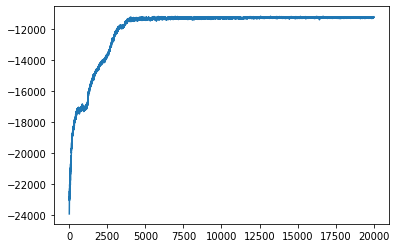

In [21]:
plt.plot(liks)

In [23]:
@jit
def sample_theta(params,key):
    
    _ ,*subkeys = random.split(key,6)

    b0 = random.dirichlet(subkeys[0],jax.nn.relu(params[0])+1e-5)
    O  = random.dirichlet(subkeys[2],jax.nn.relu(params[1]))
    T  = random.dirichlet(subkeys[1],jax.nn.relu(params[2]))
    
    O = np.concatenate((O, np.ones((S,Z))[None,:,:]), axis=0)

    T = np.concatenate((T, np.eye(S)[:,None,:]), axis=1)
    
    mu = (random.normal(subkeys[3],shape=(A,S)) * keep_pos(params[3][:,:,1])) + params[3][:,:,0]
    eta = random.gamma(subkeys[4],keep_pos(params[4][0]))*keep_pos(params[4][1])
    
    return b0,O,T,mu,eta

In [24]:
b0,O,T,mu,eta = sample_theta(par,key)

In [67]:
import matplotlib.ticker as MT
import matplotlib.lines as L
import matplotlib.cm as CM
import matplotlib.colors as C
import matplotlib.patches as PA

def decision_boundary(mu):

    means = projectSimplex(jax.nn.softmax(mu))
    a = means[0,0]
    b = means[0,1]
    c = means[1,0]
    d = means[1,1]

    db = onp.zeros((2,2))
    db[0,0] = (a**2 + b**2 - c**2 - d**2) / (2*(a-c))


    db[1,0] = (a**2 + b**2 - c**2 - d**2) / (2* \
            ((a-c)+(onp.sqrt(3)*(b-d))))
    db[1,1] = (a**2 + b**2 - c**2 - d**2 - (2*db2[0]*(a-c))) / (2* (b-d))
    
    return db

In [44]:
def projectSimplex(points):
    """ 
    Project probabilities on the 3-simplex to a 2D triangle
    
    N points are given as N x 3 array
    """
    # Convert points one at a time
    tripts = onp.zeros((points.shape[0],2))
    for idx in range(points.shape[0]):
        # Init to triangle centroid
        x = 1.0 / 2
        y = 1.0 / (2 * onp.sqrt(3))
        # Vector 1 - bisect out of lower left vertex 
        p1 = points[idx, 0]
        x = x - (1.0 / onp.sqrt(3)) * p1 * onp.cos(onp.pi / 6)
        y = y - (1.0 / onp.sqrt(3)) * p1 * onp.sin(onp.pi / 6)
        # Vector 2 - bisect out of lower right vertex  
        p2 = points[idx, 1]  
        x = x + (1.0 / onp.sqrt(3)) * p2 * onp.cos(onp.pi / 6)
        y = y - (1.0 / onp.sqrt(3)) * p2 * onp.sin(onp.pi / 6)        
        # Vector 3 - bisect out of top vertex
        p3 = points[idx, 2]
        y = y + (1.0 / onp.sqrt(3) * p3)
      
        tripts[idx,:] = (x,y)

    return tripts

In [100]:
def plot_traj(traj,samples=1000,save=None):
    
    bs = onp.zeros((samples,tau+1,3))
    mus = onp.zeros((samples,2,3))
    key = random.PRNGKey(0)
    for i in range(samples):
        key,subkey = random.split(key)
        b0,O,T,mu,eta = sample_theta(par,key)
        mus[i,:,:] = mu
        b = [None] * (tau+1)
        b[0] = b0
        for t in range(tau):
            b[t+1] = np.ravel(O[traj[0,t],:,traj[1,t],None] * T[:,traj[0,t],:].T @ b[t][:,None])
            b[t+1] = b[t+1] / b[t+1].sum()
        bs[i,:,:] = onp.array(b)
        
    bs_mean = bs.mean(axis=0)
    b_simp = projectSimplex(bs_mean)
    b_simp_d = onp.array([b_simp[i+1,:]-b_simp[i,:] for i in range(tau-1)])
    
    
    vertexlabels=['NL','Dementia','MCI']

    fig = plt.figure(figsize=(8,8))
    
    l1 = L.Line2D([0, 0.5, 1.0, 0], # xcoords
                [0, onp.sqrt(3) / 2, 0, 0], # ycoords
                color='k')
    fig.gca().add_line(l1)
    fig.gca().xaxis.set_major_locator(MT.NullLocator())
    fig.gca().yaxis.set_major_locator(MT.NullLocator())
    fig.gca().text(-0.05, -0.05, vertexlabels[0])
    fig.gca().text(1.05, -0.05, vertexlabels[1])
    fig.gca().text(0.5, onp.sqrt(3) / 2 + 0.05, vertexlabels[2])


    #plt.scatter(projected[:,0], projected[:,1])

    #plt.arrow(b_simp[0,0],b_simp[0,1],b_simp[1,0]-b_simp[0,0],b_simp[1,1]-b_simp[0,1],
    #          width=0.007,length_includes_head=True,color='black')

    for i in range(samples):
        projected = projectSimplex(bs[i])
        plt.plot(projected[:,0], projected[:,1],alpha=0.01,color='cornflowerblue',zorder=1)
    
        db = decision_boundary(mus[i])
        plt.plot(db[:,0],db[:,1],color='red',alpha=0.005)

    for i in range(tau-1):
        if i ==0:
            plt.arrow(b_simp[i,0],b_simp[i,1],b_simp_d[i,0],b_simp_d[i,1],
                  width=0.007,length_includes_head=True,color='blue',zorder=5,label='Expected Trajectory')
        else:
            plt.arrow(b_simp[i,0],b_simp[i,1],b_simp_d[i,0],b_simp_d[i,1],
                  width=0.007,length_includes_head=True,color='blue',zorder=5)

    action1 = projectSimplex(bs_mean[:-1,:][traj[0,:]==1,:])
    action0 = projectSimplex(bs_mean[:-1,:][traj[0,:]!=1,:])
    
    plt.scatter(action0[:,0], action0[:,1],color='red',s=50,zorder=10,label ='MRI not ordered')
    plt.scatter(action1[:,0], action1[:,1],color='green',s=50,zorder=10,label ='MRI ordered')

    decision = PA.Patch(color='red', label='Decision boundary density')
    dynamics = PA.Patch(color='blue', label='Trajectory density')

    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(decision)
    handles.append(dynamics)

    fig.gca().set_xlim(-0.2, 1.2)
    fig.gca().set_ylim(-0.2, 1.2)
    plt.legend(handles=handles)
    if save:
        plt.savefig(save)
    plt.show()

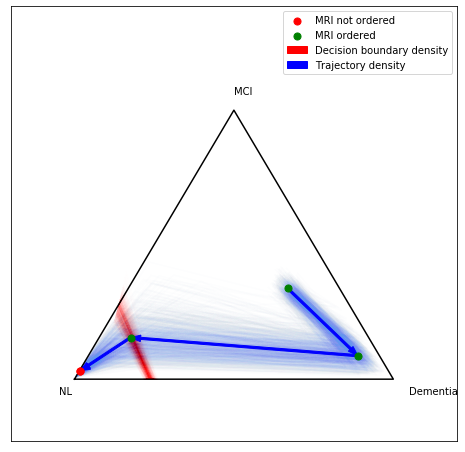

In [115]:
plot_traj(trajs[907],1000,'sample_traj2.pdf')

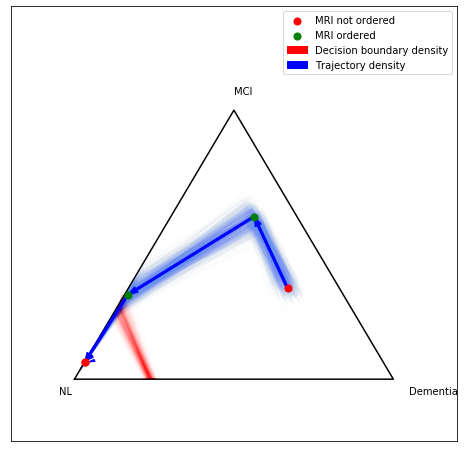

In [101]:
plot_traj(trajs[50],1000,'sample_traj.pdf')